Name: Antony Krymski

Username: agk-123

In [185]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use("bmh")
plt.rcParams.update({'font.size': 10})

def scale(a):
    # minmax scaling 
    maxv = np.max(a, axis=0)
    minv = np.min(a, axis=0)
    return (a - minv) / (maxv - minv) * 2. - 1.

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(np.floor(len(X) * (1 - test_size)))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

def plot(x):
    plt.figure(figsize=(16, 2))
    plt.margins(x=0, y=0)
    plt.plot(x)
    plt.show()

def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.margins(x=0, y=0)
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_timeseries(**kwargs):
    fig, (ax) = plt.subplots(1, 1, sharex=True, figsize=(16, 2))
    ax.margins(x=0, y=0)
    index = kwargs['index'] if 'index' in kwargs else None
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        elif key == 'index':
            pass
        else:
            if index is None:
                ax.plot(value, label=key)
            else:
                ax.plot(index, value, label=key)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_training(history, metric='loss'):
    plot_timeseries(index=range(history.params['epochs']), title=metric, train=history.history[metric], test=history.history['val_' + metric])

In [187]:
WINDOWS = 10
TIMESTEPS = 25
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 256

# Data

# Pre-processing

In [188]:
# Download our time series 
timeseries = download('JPY=X')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1996-11-04    0.003342
1996-11-05    0.003244
1996-11-06   -0.002629
1996-11-11   -0.005564
1996-11-12    0.001888
                ...   
2024-08-22   -0.001577
2024-08-23    0.007442
2024-08-26   -0.015176
2024-08-27    0.003577
2024-08-27   -0.003938
Name: Close, Length: 7188, dtype: float64

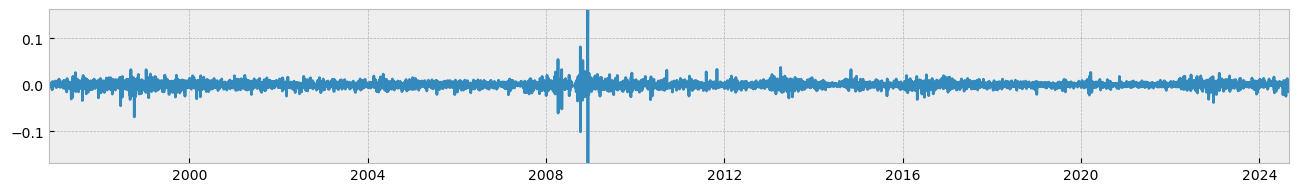

In [189]:
plot(timeseries)

Outliers 0.021905543507457815
(5550, 250) (1388, 250)
(5550,) (1388,)


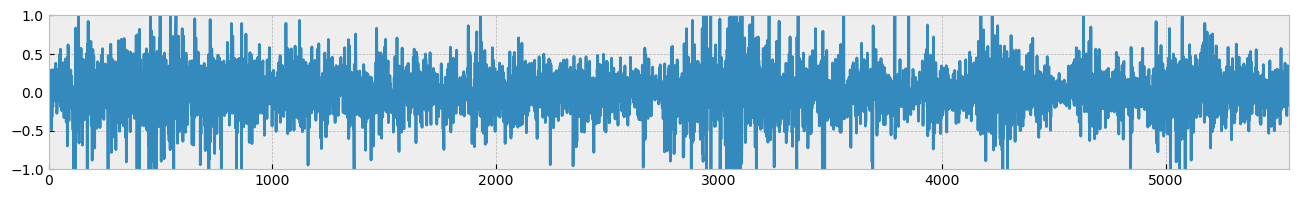

In [190]:
def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

plot(x_train[:, 0])

In [191]:
evals = pd.DataFrame(index=['RMSE', 'MAE'])

def eval(name, y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evals[name] = [ rmse, mae ]

In [192]:
# Base cases
eval('Persistence', y_test.shift(1).fillna(0), y_test)
eval('Zero', np.zeros(len(y_test)), y_test)
eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistence,Zero,Mean
RMSE,0.007789,0.005561,0.005565
MAE,0.005545,0.003883,0.003890


In [193]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
eval('LR', model.predict(x_test), y_test)

In [194]:
# # ARIMA
# import pmdarima as pm
# model = pm.auto_arima(x_train[:, -1], stationary=True, maxiter=5)
# eval('ARIMA', model.predict(len(x_test)), y_test)

In [195]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

Epoch 1/15
22/22 [==============================] - 8s 209ms/step - loss: 2.3626e-04 - mae: 0.0090 - val_loss: 4.2040e-05 - val_mae: 0.0048
Epoch 2/15
22/22 [==============================] - 2s 91ms/step - loss: 9.1747e-05 - mae: 0.0070 - val_loss: 4.5617e-05 - val_mae: 0.0052
Epoch 3/15
22/22 [==============================] - 2s 89ms/step - loss: 8.7246e-05 - mae: 0.0067 - val_loss: 4.1390e-05 - val_mae: 0.0048
Epoch 4/15
22/22 [==============================] - 3s 124ms/step - loss: 7.5008e-05 - mae: 0.0060 - val_loss: 5.1105e-05 - val_mae: 0.0056
Epoch 5/15
22/22 [==============================] - 2s 91ms/step - loss: 7.1364e-05 - mae: 0.0058 - val_loss: 3.2883e-05 - val_mae: 0.0040
Epoch 6/15
22/22 [==============================] - 2s 91ms/step - loss: 7.0395e-05 - mae: 0.0057 - val_loss: 3.1300e-05 - val_mae: 0.0039
Epoch 7/15
22/22 [==============================] - 2s 104ms/step - loss: 6.9201e-05 - mae: 0.0056 - val_loss: 4.1101e-05 - val_mae: 0.0049
Epoch 8/15
22/22 [======

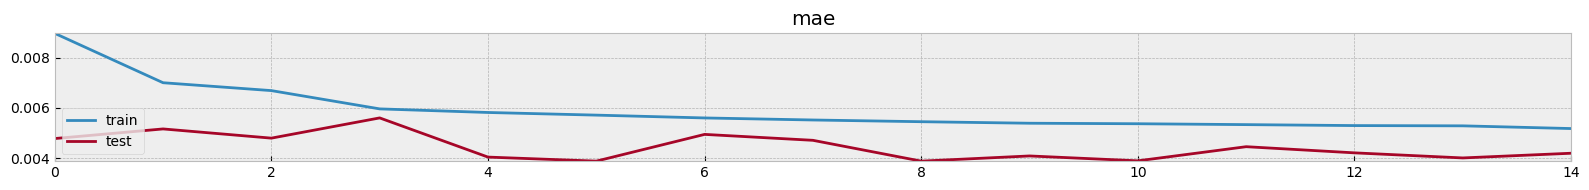

44/44 [==============================] - 1s 21ms/step


In [196]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=15, validation_data=(x_test, y_test))
plot_training(history, 'mae')

eval('LSTM', model.predict(x_test), y_test)

In [197]:
evals

,Persistence,Zero,Mean,LR,LSTM
RMSE,0.007789,0.005561,0.005565,0.00576,0.005894
MAE,0.005545,0.003883,0.003890,0.00405,0.004194


# Data Generation

In [287]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS):
        self.timesteps = timesteps
        self.n_windows = n_windows
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * n_windows) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        return self.data[idx:idx+self.timesteps, 0]
    
    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            windows = []
            for w in range(self.n_windows):
                window = self.get_window(idx + (w * self.timesteps))
                windows.append(window)

            y_positive = self.get_window(idx + (self.n_windows * self.timesteps))
            
            # random window
            y_negative = self.get_window(self.indexes[np.random.randint(0, len(self.indexes))])

            # y_negative = self.get_window(idx + ((self.n_windows-1) * self.timesteps))
            # y_negative = np.random.normal(np.mean(y_negative), np.std(y_negative), len(y_negative))

            # positive sample
            x.append(windows)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(windows)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

Batches: 21
x shape: (256, 10, 25, 1), y shape: (256, 25, 1), labels shape: (256,)


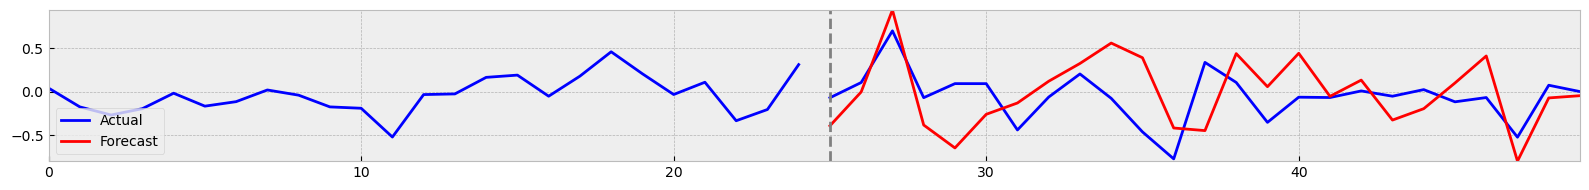

In [288]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, -1, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [289]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(128, 9, activation='relu', padding='same')(input)
    x = Conv1D(128, 9, activation='relu', padding='same')(x)
    # x = Conv1D(64, 9, activation='relu', padding='same')(x)
    x = Flatten()(x)
    # x = Dropout(0.5)(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_125 (InputLayer)      [(None, 25, 1)]           0         
                                                                 
 conv1d_71 (Conv1D)          (None, 25, 128)           1280      
                                                                 
 conv1d_72 (Conv1D)          (None, 25, 128)           147584    
                                                                 
 flatten_27 (Flatten)        (None, 3200)              0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                102432    
                                                                 
Total params: 251,296
Trainable params: 251,296
Non-trainable params: 0
_________________________________________________________________


In [290]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # x = LSTM(128, return_sequences=True, name="context")(input)
    # x = Dropout(0.5)(x)
    # x = LSTM(64, return_sequences=True, name="context")(input)
    # x = Dropout(0.5)(x)
    x = GRU(32, return_sequences=False, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((WINDOWS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_126 (InputLayer)      [(None, 10, 32)]          0         
                                                                 
 context (GRU)               (None, 32)                6336      
                                                                 
 preds (Dense)               (None, 32)                1056      
                                                                 
Total params: 7,392
Trainable params: 7,392
Non-trainable params: 0
_________________________________________________________________


In [291]:
x_input = Input((WINDOWS, TIMESTEPS, FEATURES))
x_encoded = TimeDistributed(encoder)(x_input)

y_pred = context(x_encoded)

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

output = K.mean(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_127 (InputLayer)         [(None, 10, 25, 1)]  0           []                               
                                                                                                  
 input_128 (InputLayer)         [(None, 25, 1)]      0           []                               
                                                                                                  
 time_distributed_23 (TimeDistr  (None, 10, 32)      251296      ['input_127[0][0]']              
 ibuted)                                                                                          
                                                                                                  
 encoder (Functional)           (None, 32)           251296      ['input_128[0][0]']            

In [292]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True)

In [294]:
history = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10
21/21 [==============================] - 2s 88ms/step - loss: 0.6128 - binary_accuracy: 0.6468 - val_loss: 0.6925 - val_binary_accuracy: 0.5752
Epoch 2/10
21/21 [==============================] - 2s 80ms/step - loss: 0.5999 - binary_accuracy: 0.6585 - val_loss: 0.7226 - val_binary_accuracy: 0.5889
Epoch 3/10
21/21 [==============================] - 2s 80ms/step - loss: 0.6134 - binary_accuracy: 0.6471 - val_loss: 0.7281 - val_binary_accuracy: 0.5918
Epoch 4/10
21/21 [==============================] - 2s 80ms/step - loss: 0.6011 - binary_accuracy: 0.6596 - val_loss: 0.7013 - val_binary_accuracy: 0.6084
Epoch 5/10
21/21 [==============================] - 2s 80ms/step - loss: 0.5890 - binary_accuracy: 0.6685 - val_loss: 0.6837 - val_binary_accuracy: 0.5986
Epoch 6/10
21/21 [==============================] - 2s 82ms/step - loss: 0.5839 - binary_accuracy: 0.6752 - val_loss: 0.6661 - val_binary_accuracy: 0.6455
Epoch 7/10
21/21 [==============================] - 2s 81ms/step - los

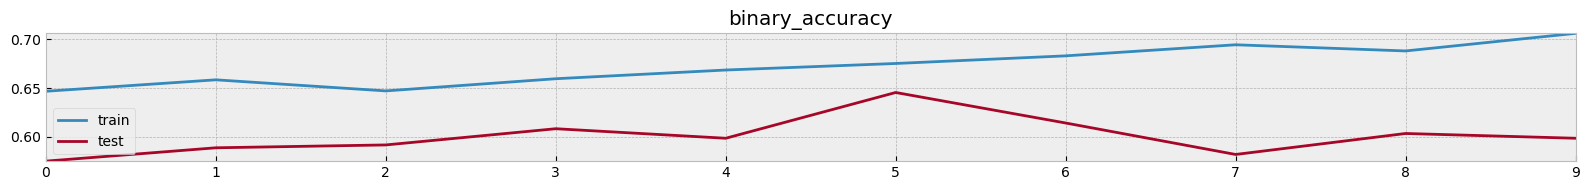

In [295]:
plot_training(history, 'binary_accuracy')

In [296]:
encoder.save('encoder.h5')

# Downstream Task

In [297]:
encoder = load_model('encoder.h5', compile=True)

In [298]:
x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
x_train.shape

Outliers 0.021905543507457815


(5730, 25)

In [299]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)

45/45 [==============================] - 0s 3ms/step


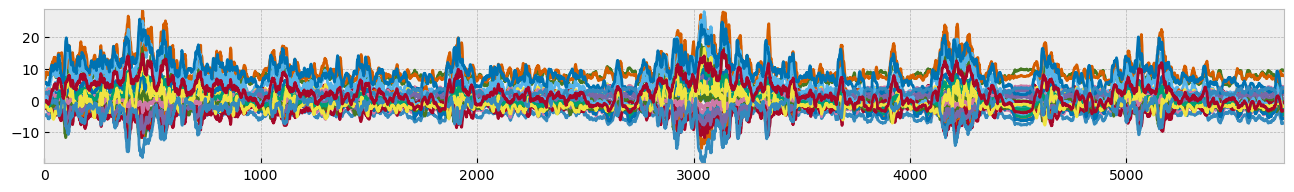

In [300]:
plot(x_train_embeds)

In [301]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

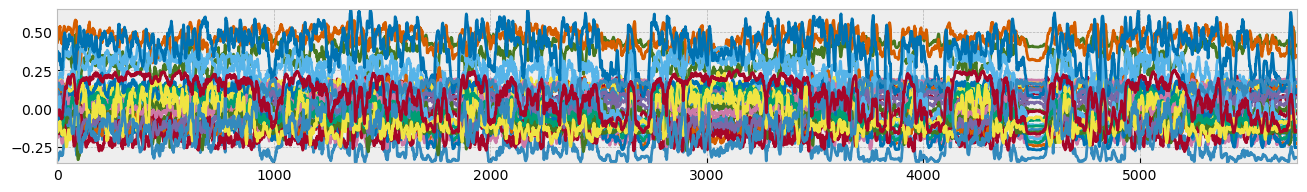

In [302]:
plot(x_train_embeds)

In [303]:
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans

# # Apply t-SNE for visualization
# tsne = TSNE(n_components=2, perplexity=30, n_iter=350)
# embeddings_tsne = tsne.fit_transform(x_train_embeds)

# # Apply K-means clustering
# kmeans = KMeans(n_clusters=6)
# clusters = kmeans.fit_predict(x_train_embeds)

# # Visualize the clusters using the t-SNE embeddings
# plt.figure(figsize=(8, 8))
# plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
# plt.title('Cluster analysis of CPC embeddings')
# plt.show()

In [304]:
# Linear Regression with CPC embeddings
model = LinearRegression()
model.fit(x_train_embeds, y_train)
eval('CPC-LR', model.predict(x_test_embeds), y_test)
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR,CPC
RMSE,0.007789,0.005561,0.005565,0.00576,0.005894,0.005520,0.005548
MAE,0.005545,0.003883,0.003890,0.00405,0.004194,0.003845,0.003924


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_129 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_59 (Dense)            (None, 64)                2112      
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 64)                4160      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

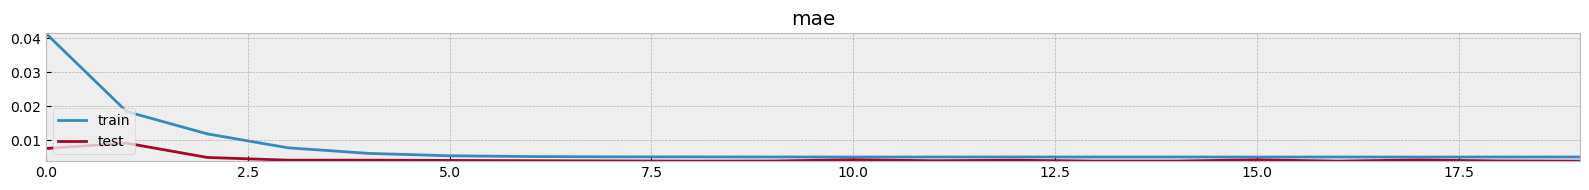

45/45 [==============================] - 0s 2ms/step


In [305]:
def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train_embeds, y_train, batch_size=BATCH_SIZE, epochs=20, validation_data=(x_test_embeds, y_test))
plot_training(history, 'mae')

eval('CPC', model.predict(x_test_embeds), y_test)

In [306]:
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR,CPC
RMSE,0.007789,0.005561,0.005565,0.00576,0.005894,0.005520,0.005491
MAE,0.005545,0.003883,0.003890,0.00405,0.004194,0.003845,0.003820


# Optimize Sharpe

In [314]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_132 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_68 (Dense)            (None, 64)                2112      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_70 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable 

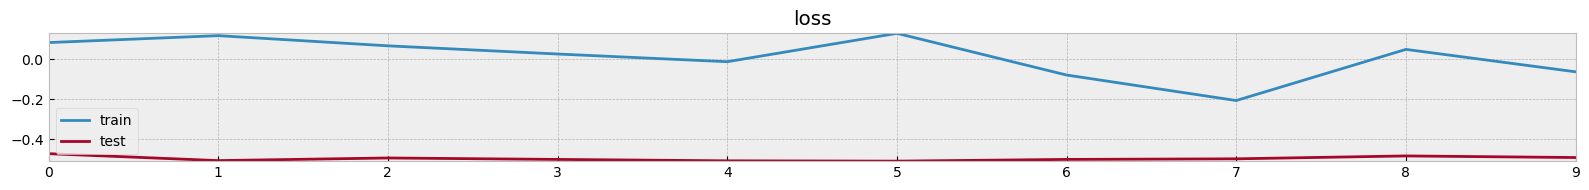

In [315]:
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(input, x)

model = build_dense((CODE_SIZE))
model.compile(loss=sharpe_loss, optimizer='adam')
model.summary()

history = model.fit(x_train_embeds, train_returns, batch_size=252, epochs=10, validation_data=(x_test_embeds, test_returns))
plot_training(history, 'loss')


In [316]:
allocations = model.predict(x_test_embeds)[:, 0]
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

45/45 [==============================] - 0s 3ms/step
Strategy Sharpe 0.38835316834623357
Benchmark Sharpe 0.5283829307611403


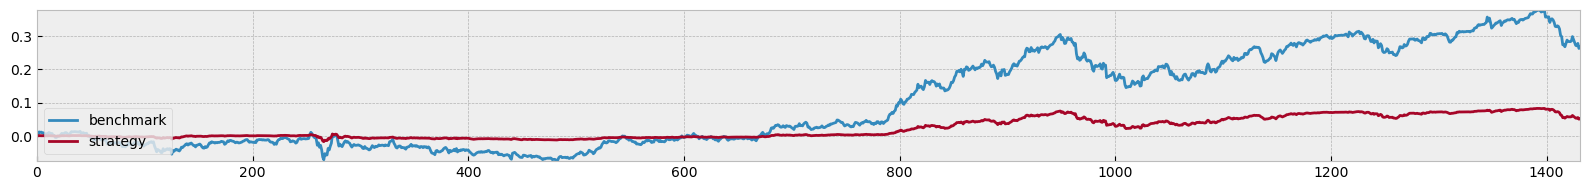

In [317]:
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

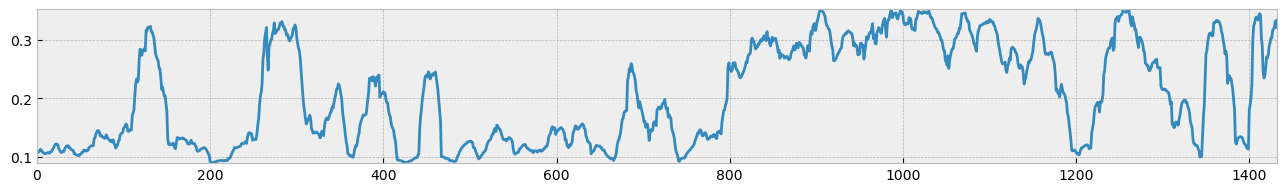

In [318]:
plot(allocations)